# HomeCreditの返済予測

## 必要なモジュールのインポート

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%  matplotlib inline

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

from scipy import stats

pd.set_option('display.max_columns', 100)
import pandas_profiling as pdp


import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

/Users/hiroshi/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


##  データのロード

In [2]:
df_train=pd.read_csv("application_train.csv")
df_test=pd.read_csv("application_test.csv")
total_data=pd.concat([df_train,df_test])

## データサイズの確認

In [3]:
df_train.shape,df_test.shape,total_data.shape

((307511, 122), (48744, 121), (356255, 122))

##  含まれているデータ型の確認

どんな型のデータが含まれているのか確認する。

In [4]:
total_data.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('O')], dtype=object)

##  欠損値の確認

In [5]:
total_data.isnull().any().any()

True

欠損値が混じっているようです。もう少し詳しく確認してみましょう。欠損値を含んでいるカラムを抽出します。

In [6]:
total_anynull_df=total_data.loc[:,total_data.isnull().any()]
total_anynull_df.shape,total_data.shape
# list(df_anynull_df.columns) ,len(list(df_anynull_df.columns))

((356255, 68), (356255, 122))

どの特徴量がどれくらい欠損値を含んでいるかみてみましょう。欠損値が多い順にソートします。

In [7]:
pd.set_option('display.max_rows', 500)
total_anynull_df_count=total_anynull_df.isnull().sum().sort_values(ascending = False).reset_index()
total_anynull_df_count

,index,0
0,COMMONAREA_MODE,248360
1,COMMONAREA_AVG,248360
2,COMMONAREA_MEDI,248360
3,NONLIVINGAPARTMENTS_MEDI,246861
4,NONLIVINGAPARTMENTS_MODE,246861
5,NONLIVINGAPARTMENTS_AVG,246861
6,FONDKAPREMONT_MODE,243092
7,LIVINGAPARTMENTS_AVG,242979
8,LIVINGAPARTMENTS_MEDI,242979
9,LIVINGAPARTMENTS_MODE,242979


# 欠損値の種類

ここで欠損値の種類について一般論を確認しておく。

欠損値には以下のように、大きく分けて3種類ある。(Little and Rubin, 2002, pp.11-12,　pp.312-313)。

- Missing Completely At Random (MCAR):完全にランダムな欠損。

- Missing At Random (MAR):別の変数に依存して発生している欠損

- Missing Not At Random (MNAR):その変数自体に原因がある場合。


それぞれに応じて欠損値の処理方法もいろいろあるようだが、完全情報最尤推定法もしくは多重代入法と呼ばれる方法であれば、もとの情報を損失せずに補完できるようである。

その他に、欠損が上記分類のどれに該当するのかを統計処理で確認する方法や、欠損の種類に対する処理の仕方がどのくらい影響するのかといった部分なども確認する必要がある。


欠損の種類の詳細の分析までは立ちいらず、すぐに

以下のコードについては、モデルにかける前のいわゆる前処理の部分については関数を定義し内部で処理をする方向性でいく。

In [8]:
def Drop_nan(Data):
     
     # 自動車を所有していない人は、"OWN_CAR_AGE"がnanになっているので、0で埋める。
    Data["OWN_CAR_AGE"]=Data["OWN_CAR_AGE"].fillna(0)
    
    
    #  欠損が20000以上ある特徴量は削除することにする。
    total_anynull_df_dropNull  =  Data.dropna(thresh=200000,axis=1)
    total_anynull_df_dropNull.shape,    Data.shape
    pd.DataFrame(total_anynull_df_dropNull.isnull().sum().sort_values(ascending=False))
    
    
    # "OCCUPATION_TYPE"の欠損の穴埋め。nanのところは"No workとして穴埋め。"
    total_anynull_df_dropNull["OCCUPATION_TYPE"].unique()
    total_anynull_df_dropNull["OCCUPATION_TYPE"]=total_anynull_df_dropNull["OCCUPATION_TYPE"].fillna("No work")
    
    #  "CNT_FAM_MEMBERS"の欠損の穴埋め。nanは中央値で穴埋め。
    total_anynull_df_dropNull["CNT_FAM_MEMBERS"]=total_anynull_df_dropNull["CNT_FAM_MEMBERS"] .fillna(total_anynull_df_dropNull["CNT_FAM_MEMBERS"].median())
    total_anynull_df_dropNull["CNT_FAM_MEMBERS"].isnull().any()
    
    
    #  "DAYS_LAST_PHONE_CHANGE"の欠損の穴埋め。nanは中央値で穴埋め。
    total_anynull_df_dropNull["DAYS_LAST_PHONE_CHANGE"]=total_anynull_df_dropNull["DAYS_LAST_PHONE_CHANGE"] .fillna(total_anynull_df_dropNull["DAYS_LAST_PHONE_CHANGE"].median())
    total_anynull_df_dropNull["DAYS_LAST_PHONE_CHANGE"].isnull().any()
    
    
    #  "NAME_TYPE_SUITE"の欠損の穴埋め。nanは"Unaccompanied"で穴埋め。
    total_anynull_df_dropNull["NAME_TYPE_SUITE"]=total_anynull_df_dropNull["NAME_TYPE_SUITE"].fillna("Unaccompanied")
    total_anynull_df_dropNull["NAME_TYPE_SUITE"].isnull().any()
    
    #残りの欠損値の確認
    pd.DataFrame(total_anynull_df_dropNull.isnull().sum().sort_values(ascending=False))
    
    # 欠損値のある特徴量をリストにする。
    Null_list=list(total_anynull_df_dropNull.loc[ :,total_anynull_df_dropNull.isnull().any() ].columns)
    
    
    #  残りの欠損値については、各特徴量の平均で穴埋め。
    for i in Null_list:
        total_anynull_df_dropNull[i] = total_anynull_df_dropNull[i].fillna(total_anynull_df_dropNull[i].mean())
    
    
    #  欠損が取り除けたかどうか確認。Falseが返ってくれば問題なし。
    return pd.DataFrame(total_anynull_df_dropNull)


# ラベルエンコーダー

# label encoder のオブジェクトを生成する


def Label_encode(Data):
    le = LabelEncoder()
    le_count = 0

    for col in list(Data.columns):
        if Data[col].dtype == 'object':
            if len(list(Data[col].unique())) <= 2:
                le.fit(Data[col])

                Data[col] = le.transform(Data[col])

                #何を いくつ変換したか記録する
                print(col+"をラベルエンコード")
                le_count += 1
            
    return  Data

    
# One-Hot Encoder

def One_hot_Encode(Data):
    Data = pd.get_dummies(Data)
    return Data

    


さて、上記で欠損値に関する処理やラベルエンコーダーなどに関する処理が関数として準備できたので、関数を適用する。

In [9]:
total_data = Drop_nan(total_data)             #欠損値の処理
total_data = Label_encode(total_data)     # ラベルエンコード
total_data = One_hot_Encode(total_data)   #　ワンホットエンコーダー

FLAG_OWN_CARをラベルエンコード
FLAG_OWN_REALTYをラベルエンコード
NAME_CONTRACT_TYPEをラベルエンコード


object型で決められている特徴量を確認しましょう。

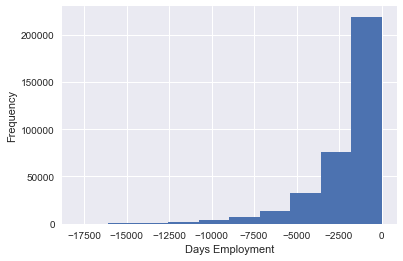

In [10]:
# 勤務日数が1000年ということになっている(=異常値)
total_data['DAYS_EMPLOYED'].describe()

err = total_data[total_data['DAYS_EMPLOYED'] == 365243]
not_err = total_data[total_data['DAYS_EMPLOYED'] != 365243]

# Create an err flag column
total_data['DAYS_EMPLOYED_err'] = total_data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
total_data['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

# グラフで消えたのを確認する
total_data['DAYS_EMPLOYED'].plot.hist();
plt.xlabel('Days Employment');

さて、トレーニングデータを目的変数と説明変数に分離して準備しよう。

In [11]:
# trainデータを目的変数と説明変数に分ける

y = df_train['TARGET']
# y = y.values.reshape(307511, 1)
X = total_data.iloc[:307511, :]
X_ = total_data.iloc[307511:, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)


ロジスティック関数を用意しよう。

In [12]:
from sklearn.linear_model import LogisticRegression

div=10
kf = KFold(n_splits=div)
kf_split=kf.split(X_train)
lr = LogisticRegression(C=10)


ロジスティック関数を学習させます。

In [13]:
lr.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

テストデータをモデルにかけ、確率を表示します。

In [14]:
pred=lr.predict_proba(X_)
pd.DataFrame(pred)

,0,1
0,0.912972,0.087028
1,0.906176,0.093824
2,0.945353,0.054647
3,0.968485,0.031515
4,0.920630,0.079370
5,0.970817,0.029183
6,0.885722,0.114278
7,0.845303,0.154697
8,0.860748,0.139252
9,0.882161,0.117839


submitを行う用の処理になります。

In [15]:
pred=pd.DataFrame(pred)

In [16]:
submit=pd.read_csv("sample_submission.csv")
submit['TARGET'] = pred.iloc[:,1]
submit.to_csv('Logistic_domain.csv', index = False)

In [17]:
submit.to_csv('Logistic_domain.csv', index = False)